
**This model will utilize the LSTM netwrok only to predicts next day closing price of the bitcoin.**




The next piece of code will **import the neccassary libraries** that will be used throughout the code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")
import scipy 
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.layers import *
from keras.models import *
from keras import backend as K

# Set random seed for reproducibility
tf.random.set_seed(42)

Now that we have the imported the required libraries, we need to get the data.
We will do so by first **installing the historic crypto data api**, that will allow us to get the data of any crypto (mainly the famous ones), on any range we wish, for example, we can get the bitcoin data from a chosen date to a chosen date, per 60 seconds up to per 24 hrs.

In [2]:
!pip install Historic-Crypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings("ignore")

# From the histroic cyrpto import the historical data
from Historic_Crypto import HistoricalData

Next step would be to **get the data** . The chosen data will be reterived chunk wise. Here, we will specify the name of the cryptocurrency we are interested in, for instance in our case 'BTC-USD' is the bitcoin one, then we should specify number of seconds that will seperate the data. For example, 86400 is the number of seconds in 1 day. So, we will reterive the data on a daily bases. Next, we will specify the starting date in the form of year-month-day-hour-minute and finally the ending date, in the same format.

**In our case, we will reterive data between 01/01/2021 and 31/05/2022 on daily bases.**


In [4]:
btc_historicals = HistoricalData('BTC-USD',86400,'2021-01-01-00-00', '2022-07-01-00-00').retrieve_data() # cyrpto name, number of seconds, start date, end date


Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2021-01-01T00:00:00
Provisional End: 2021-10-28T00:00:00
Data for chunk 1 of 2 extracted
Provisional Start: 2021-10-28T00:00:00
Provisional End: 2022-08-24T00:00:00
Data for chunk 2 of 2 extracted


In the next few lines, we will try to have **a closer look at the data** and check whether it needs any cleaning or not.

In [5]:
# check the shape of the data
btc_historicals.shape

(546, 5)

In [6]:
# few the last 5 rows of the data
btc_historicals.tail()

,low,high,open,close,volume
time,,,,,
2022-06-27,20500.00,21520.00,21024.85,20725.17,17440.942683
2022-06-28,20164.70,21189.99,20722.95,20252.89,17658.660417
2022-06-29,19823.43,20410.91,20253.50,20094.79,18278.451859
2022-06-30,18603.00,20143.53,20098.00,19985.62,28361.458762
2022-07-01,18938.33,20879.99,19985.62,19252.76,32977.000523


As we can observe, the data is in the form of low high open close volume, that means, on te given date, the lowest price was low, the higest price was high, the openning price was open, the closing price was close, and the volume of data that was exchanges was volume.

In [7]:
# Check out variables
btc_historicals.dtypes

low       float64
high      float64
open      float64
close     float64
volume    float64
dtype: object

In [8]:
# assign a dummy variable to hold the data, so that incase we need to do any
# modifications, we wouldn't lose the orginal data.
tst = btc_historicals

In [9]:
# The data is clean already, but let us try to check for any null or NA vales.
print('Null Values:',tst.isnull().values.sum())
print('If any NA values:', tst.isnull().values.any())

Null Values: 0
If any NA values: False


Next, we will need to do some modifications to the data we have. The first one will be to create a new variable called, Tomorrrow_Close which shifts the close price by 1 row and thus the last row will be deleted. This is done to add a new important feature so that our model will learn from. 

In [10]:
# Create variable '‘TOMORROW_CLOSE’' which shifts 'Close' up by 1
tst['TOMORROW_CLOSE'] = tst['close'].shift(-1,fill_value=0)

In [11]:
# drop last row because we shifted value (remember this when you add your forecasting data)
tst.drop(tst.tail(1).index,inplace=True) 

In [12]:
# Drop close column, since we created new ‘TOMORROW_CLOSE’
tst = tst.drop(columns=['close'])

In [13]:
tst.head()

,low,high,open,volume,TOMORROW_CLOSE
time,,,,,
2021-01-02,29039.00,33300.00,29413.29,46675.246521,33080.66
2021-01-03,32008.62,34810.00,32222.88,36951.716506,32019.99
2021-01-04,27678.00,33666.99,33082.84,46045.389685,34030.64
2021-01-05,29891.13,34499.67,32020.22,42282.569200,36859.26
2021-01-06,33352.54,37000.00,34043.91,45744.103200,39505.56


In [14]:
# check the shape of data to know how many sample we have
tst.shape

(545, 5)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web

***Technical Indicators***

In [16]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['TOMORROW_CLOSE'].rolling(window=7).mean()
    dataset['ma21'] = dataset['TOMORROW_CLOSE'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['TOMORROW_CLOSE'].ewm(span=26).mean()
    dataset['12ema'] = dataset['TOMORROW_CLOSE'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['TOMORROW_CLOSE'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['TOMORROW_CLOSE'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['TOMORROW_CLOSE']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [17]:
df = get_technical_indicators(tst)

In [18]:
df = df.dropna()
df.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,32112.01,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,32288.56,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,32261.87,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32510.82,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,30407.13,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [19]:
df.shape

(525, 16)

In [20]:
# Double check for NANS !
# The data is clean already, but let us try to check for any null or NA vales.
#print('Null Values:',tst.isnull().values.sum())
#print('If any NA values:', tst.isnull().values.any())

In [21]:
# Split the data intro train data (90%) and test data (10%)

train_size = int(len(tst)*0.90)
train_dataset, test_dataset = tst.iloc[:train_size],tst.iloc[train_size:]


In [22]:
print('Null Values:',train_dataset.isnull().values.sum())
train_dataset = train_dataset.dropna()
print('Null Values:',train_dataset.isnull().values.sum())

Null Values: 86
Null Values: 0


In [23]:
# Double check the split
train_dataset.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,32112.01,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,32288.56,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,32261.87,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32510.82,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,30407.13,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [24]:
print('Null Values:',train_dataset.isnull().values.sum())

Null Values: 0


In [25]:
# Double check the split
test_dataset.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2022-05-07,34785.00,36125.00,35999.10,11372.453192,34027.91,36846.038571,38713.734286,38779.645486,37242.221661,-1537.423825,1962.220210,42638.174706,34789.293865,34616.311410,34026.91,10.434907
2022-05-08,33701.00,35499.93,35458.00,22357.511521,30078.27,35641.378571,38203.005238,38135.099153,36140.075252,-1995.023902,2662.068970,43527.143178,32878.867298,31590.950470,30077.27,10.311525
2022-05-09,30010.00,34231.54,34033.49,55136.453328,31002.39,34681.778571,37702.935714,37606.750327,35349.662136,-2257.088191,2978.540310,43660.016335,31745.855094,31198.576823,31001.39,10.341787
2022-05-10,29735.05,32645.49,30078.27,55818.019003,28972.34,33153.604286,37112.208571,36967.164377,34368.535653,-2598.628723,3411.934849,43936.078270,30288.338873,29714.418941,28971.34,10.274062
2022-05-11,27682.38,32185.90,31002.39,61128.252963,28941.95,32068.565714,36562.739048,36372.704053,33533.676322,-2839.027731,3754.273471,44071.285990,29054.192105,29199.439647,28940.95,10.273013


In [26]:
print('Null Values:',test_dataset.isnull().values.sum())

Null Values: 0


In [27]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]

# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [28]:
# Double check the X
X_train.head()

,low,high,open,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [29]:
# Double check for x_train
print('Null Values:',X_train.isnull().values.sum())

Null Values: 0


In [30]:
# Double check for x_test

print('Null Values:',X_test.isnull().values.sum())

Null Values: 0


Dimension of train data:  (470, 16)
Dimension of test data:  (55, 16)


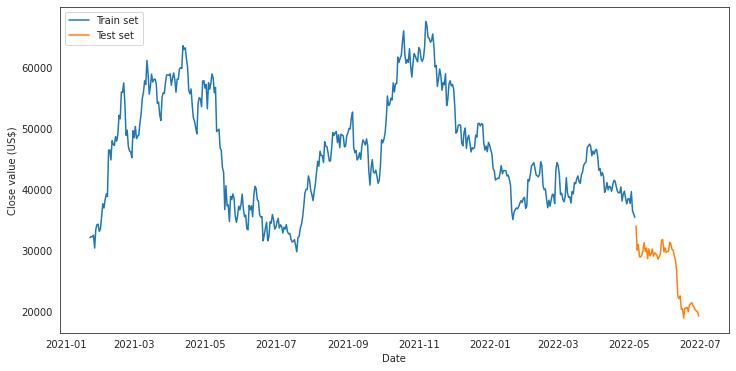

In [31]:
#Plot train and test data
fig1 = plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)
fig1.savefig('train_test_split.png')

As we can observe, we have chosen the starting date to be 01/01/2021 because of the dynamic change in the price has started around this date, and so if the model will be able to predict the daynamic behaviour later, it has to be trained on similiar behaviour data. While, the data before this date is relatively steady, and didn't help the model the learn anything from. Matter fact, it lead to poor results.
Below, is a plot of the bitcoin price evolution from 2012.

In [32]:
'''
btc = HistoricalData('BTC-USD',86400,'2012-01-01-00-00', '2022-07-01-00-00').retrieve_data() 

# Create variable '‘TOMORROW_CLOSE’' which shifts 'Close' up by 1
btc['TOMORROW_CLOSE'] = btc['close'].shift(-1,fill_value=0)

# drop last row because we shifted value (remember this when you add your forecasting data)
btc.drop(btc.tail(1).index,inplace=True) 

# Drop close column, since we created new ‘TOMORROW_CLOSE’
btc = btc.drop(columns=['close'])

# Split the data intro train data (90%) and test data (10%)

train_size_1 = int(len(btc)*0.90)
train_dataset_1, test_dataset_1 = btc.iloc[:train_size_1],btc.iloc[train_size_1:]

# Split train data to X and y
X_train_1 = train_dataset_1.drop('TOMORROW_CLOSE', axis = 1)
y_train_1 = train_dataset_1.loc[:,['TOMORROW_CLOSE']]

# Split test data to X and y
X_test_1 = test_dataset_1.drop('TOMORROW_CLOSE', axis = 1)
y_test_1 = test_dataset_1.loc[:,['TOMORROW_CLOSE']]
#Plot train and test data
fig2 = plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset_1.TOMORROW_CLOSE)
plt.plot(test_dataset_1.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset_1.shape)
print('Dimension of test data: ', test_dataset_1.shape)
fig2.savefig('entire_train_test_data.png')
'''

"\nbtc = HistoricalData('BTC-USD',86400,'2012-01-01-00-00', '2022-07-01-00-00').retrieve_data() \n\n# Create variable '‘TOMORROW_CLOSE’' which shifts 'Close' up by 1\nbtc['TOMORROW_CLOSE'] = btc['close'].shift(-1,fill_value=0)\n\n# drop last row because we shifted value (remember this when you add your forecasting data)\nbtc.drop(btc.tail(1).index,inplace=True) \n\n# Drop close column, since we created new ‘TOMORROW_CLOSE’\nbtc = btc.drop(columns=['close'])\n\n# Split the data intro train data (90%) and test data (10%)\n\ntrain_size_1 = int(len(btc)*0.90)\ntrain_dataset_1, test_dataset_1 = btc.iloc[:train_size_1],btc.iloc[train_size_1:]\n\n# Split train data to X and y\nX_train_1 = train_dataset_1.drop('TOMORROW_CLOSE', axis = 1)\ny_train_1 = train_dataset_1.loc[:,['TOMORROW_CLOSE']]\n\n# Split test data to X and y\nX_test_1 = test_dataset_1.drop('TOMORROW_CLOSE', axis = 1)\ny_test_1 = test_dataset_1.loc[:,['TOMORROW_CLOSE']]\n#Plot train and test data\nfig2 = plt.figure(figsize = (12,

**Data Normalization**

In [33]:
# Different scaler for input and output ----> Normalizate the data
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

**Prepare the data to be fed into the model.
Create 3 D tensor of data.**

In [34]:
# Create 3 dimensional data set 
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 15 # which means the model will make predictions of ‘TOMORROW_CLOSE’ based on the input from the 10 previous days or future days bi-lstm or bi-gru

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (455, 15, 15)
y_train.shape:  (455, 1)
X_test.shape:  (40, 15, 15)
y_test.shape:  (40, 1)


**FINALLY, we can CONSTUCT the MODEL**

In [35]:
# Create LSTM 
def create_model(m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = 128, activation = 'relu', return_sequences = False, input_shape = [X_train.shape[1], X_train.shape[2]]))

    '''
    model.add(m (units = 256, activation = 'relu', return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]])) # use 64 hidden units, relu acitvation function,
    model.add(Dropout(0.3))
    model.add(m (units = 128, activation = 'relu', return_sequences = False, input_shape = [X_train.shape[1], X_train.shape[2]])) # use 64 hidden units, relu acitvation function,
    model.add(Dropout(0.3))
    '''
    # return_sequence is False, because we will use one layer LSTM
    # Add a dense layer
    model.add(Dense(units = 1))  # number of units is 1, because we will predict one output, which is tomorrow's price and compare it with the ground truth  
    model.compile(loss = 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4 ) ) # use loss as MSE and Adam optimizer, with learning rate 0.000001
    return model

In [36]:
# Create the model by passing LSTM to the model.
model_lstm = create_model(LSTM)

In [37]:
# Let's check the summary of our baby model
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73728     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 73,857
Trainable params: 73,857
Non-trainable params: 0
_________________________________________________________________


In [38]:
# start the  training process, with 800 epochs, (the number of times the model will look at the entire dataset), validation split is 20 % from the training data, this is
# done autmatically by Keras, batch size of 8, meaning that, the model will take try to minimize the loss by looking at only 8 samples, shuffle is false, because this is time 
# data, so the order matters alot.
history_lstm = model_lstm.fit(X_train, y_train, epochs = 50, validation_split = 0.2,batch_size = 16, shuffle = False) 

Epoch 1/50
23/23 [==============================] - 2s 29ms/step - loss: 0.2729 - val_loss: 0.2020
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.1822 - val_loss: 0.1323
Epoch 3/50
23/23 [==============================] - 0s 18ms/step - loss: 0.1214 - val_loss: 0.0811
Epoch 4/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0819 - val_loss: 0.0477
Epoch 5/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0601 - val_loss: 0.0312
Epoch 6/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0508 - val_loss: 0.0260
Epoch 7/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0464 - val_loss: 0.0249
Epoch 8/50
23/23 [==============================] - 1s 29ms/step - loss: 0.0426 - val_loss: 0.0246
Epoch 9/50
23/23 [==============================] - 1s 28ms/step - loss: 0.0392 - val_loss: 0.0243
Epoch 10/50
23/23 [==============================] - 1s 33ms/step - loss: 0.0362 - val_loss: 0.0241
Epoch 11/

As we can observe, the loss is the training loss, and val_loss is the validation loss. Both are decereasing smoothly as the number of epochs is increasing, that means, our **model is learning in a natural way**.

Next, **let's plot the validation and train error**, to check for any problems that a model can suffer from, such as underfitting or overfitting.

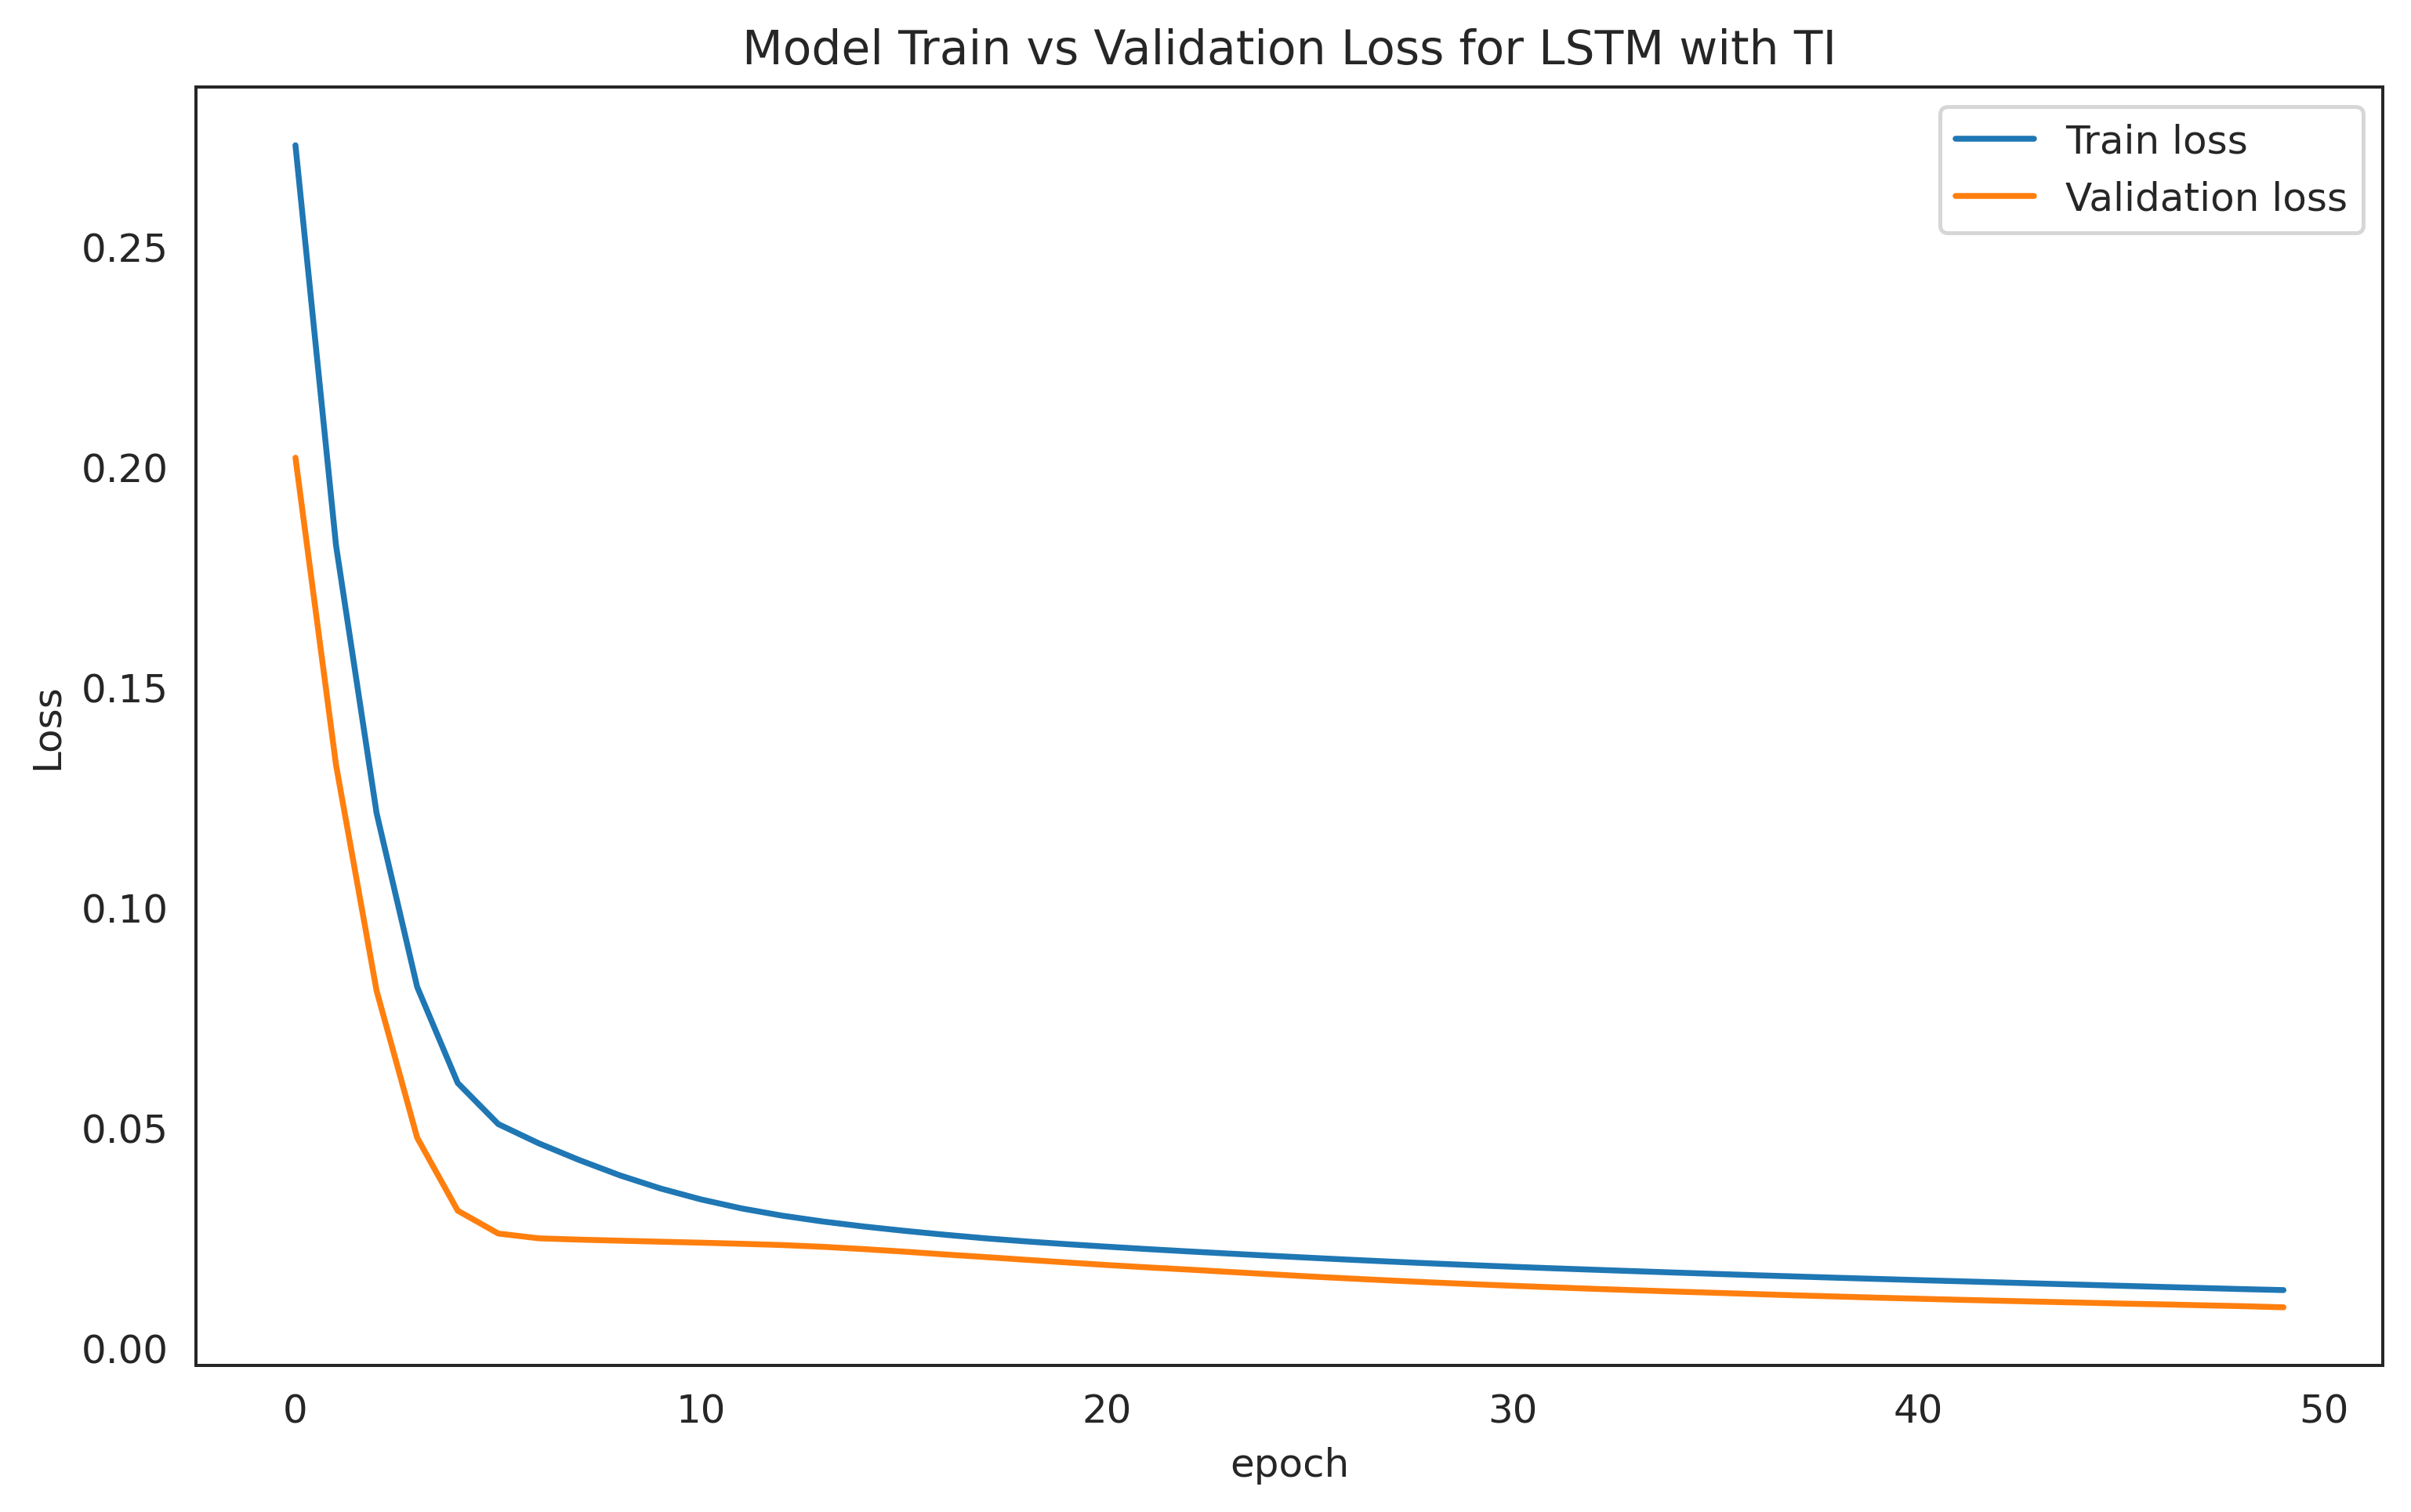

In [39]:
#Plot train and validation loss
def plot_loss (history, model_name):
    fig3 = plt.figure(figsize = (10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name + ' with TI')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    fig3.savefig('Model_Train_vs_Validation_Loss_for_LSTM_with_TI.png')
plot_loss (history_lstm, 'LSTM')


Before we start the testing phase, we need to inverse the normalization process that we applied to the data.

In [40]:
# inverse the y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

Define a function to inverse the X

In [41]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [42]:
# Do predictions
prediction_LSTM = prediction(model_lstm)

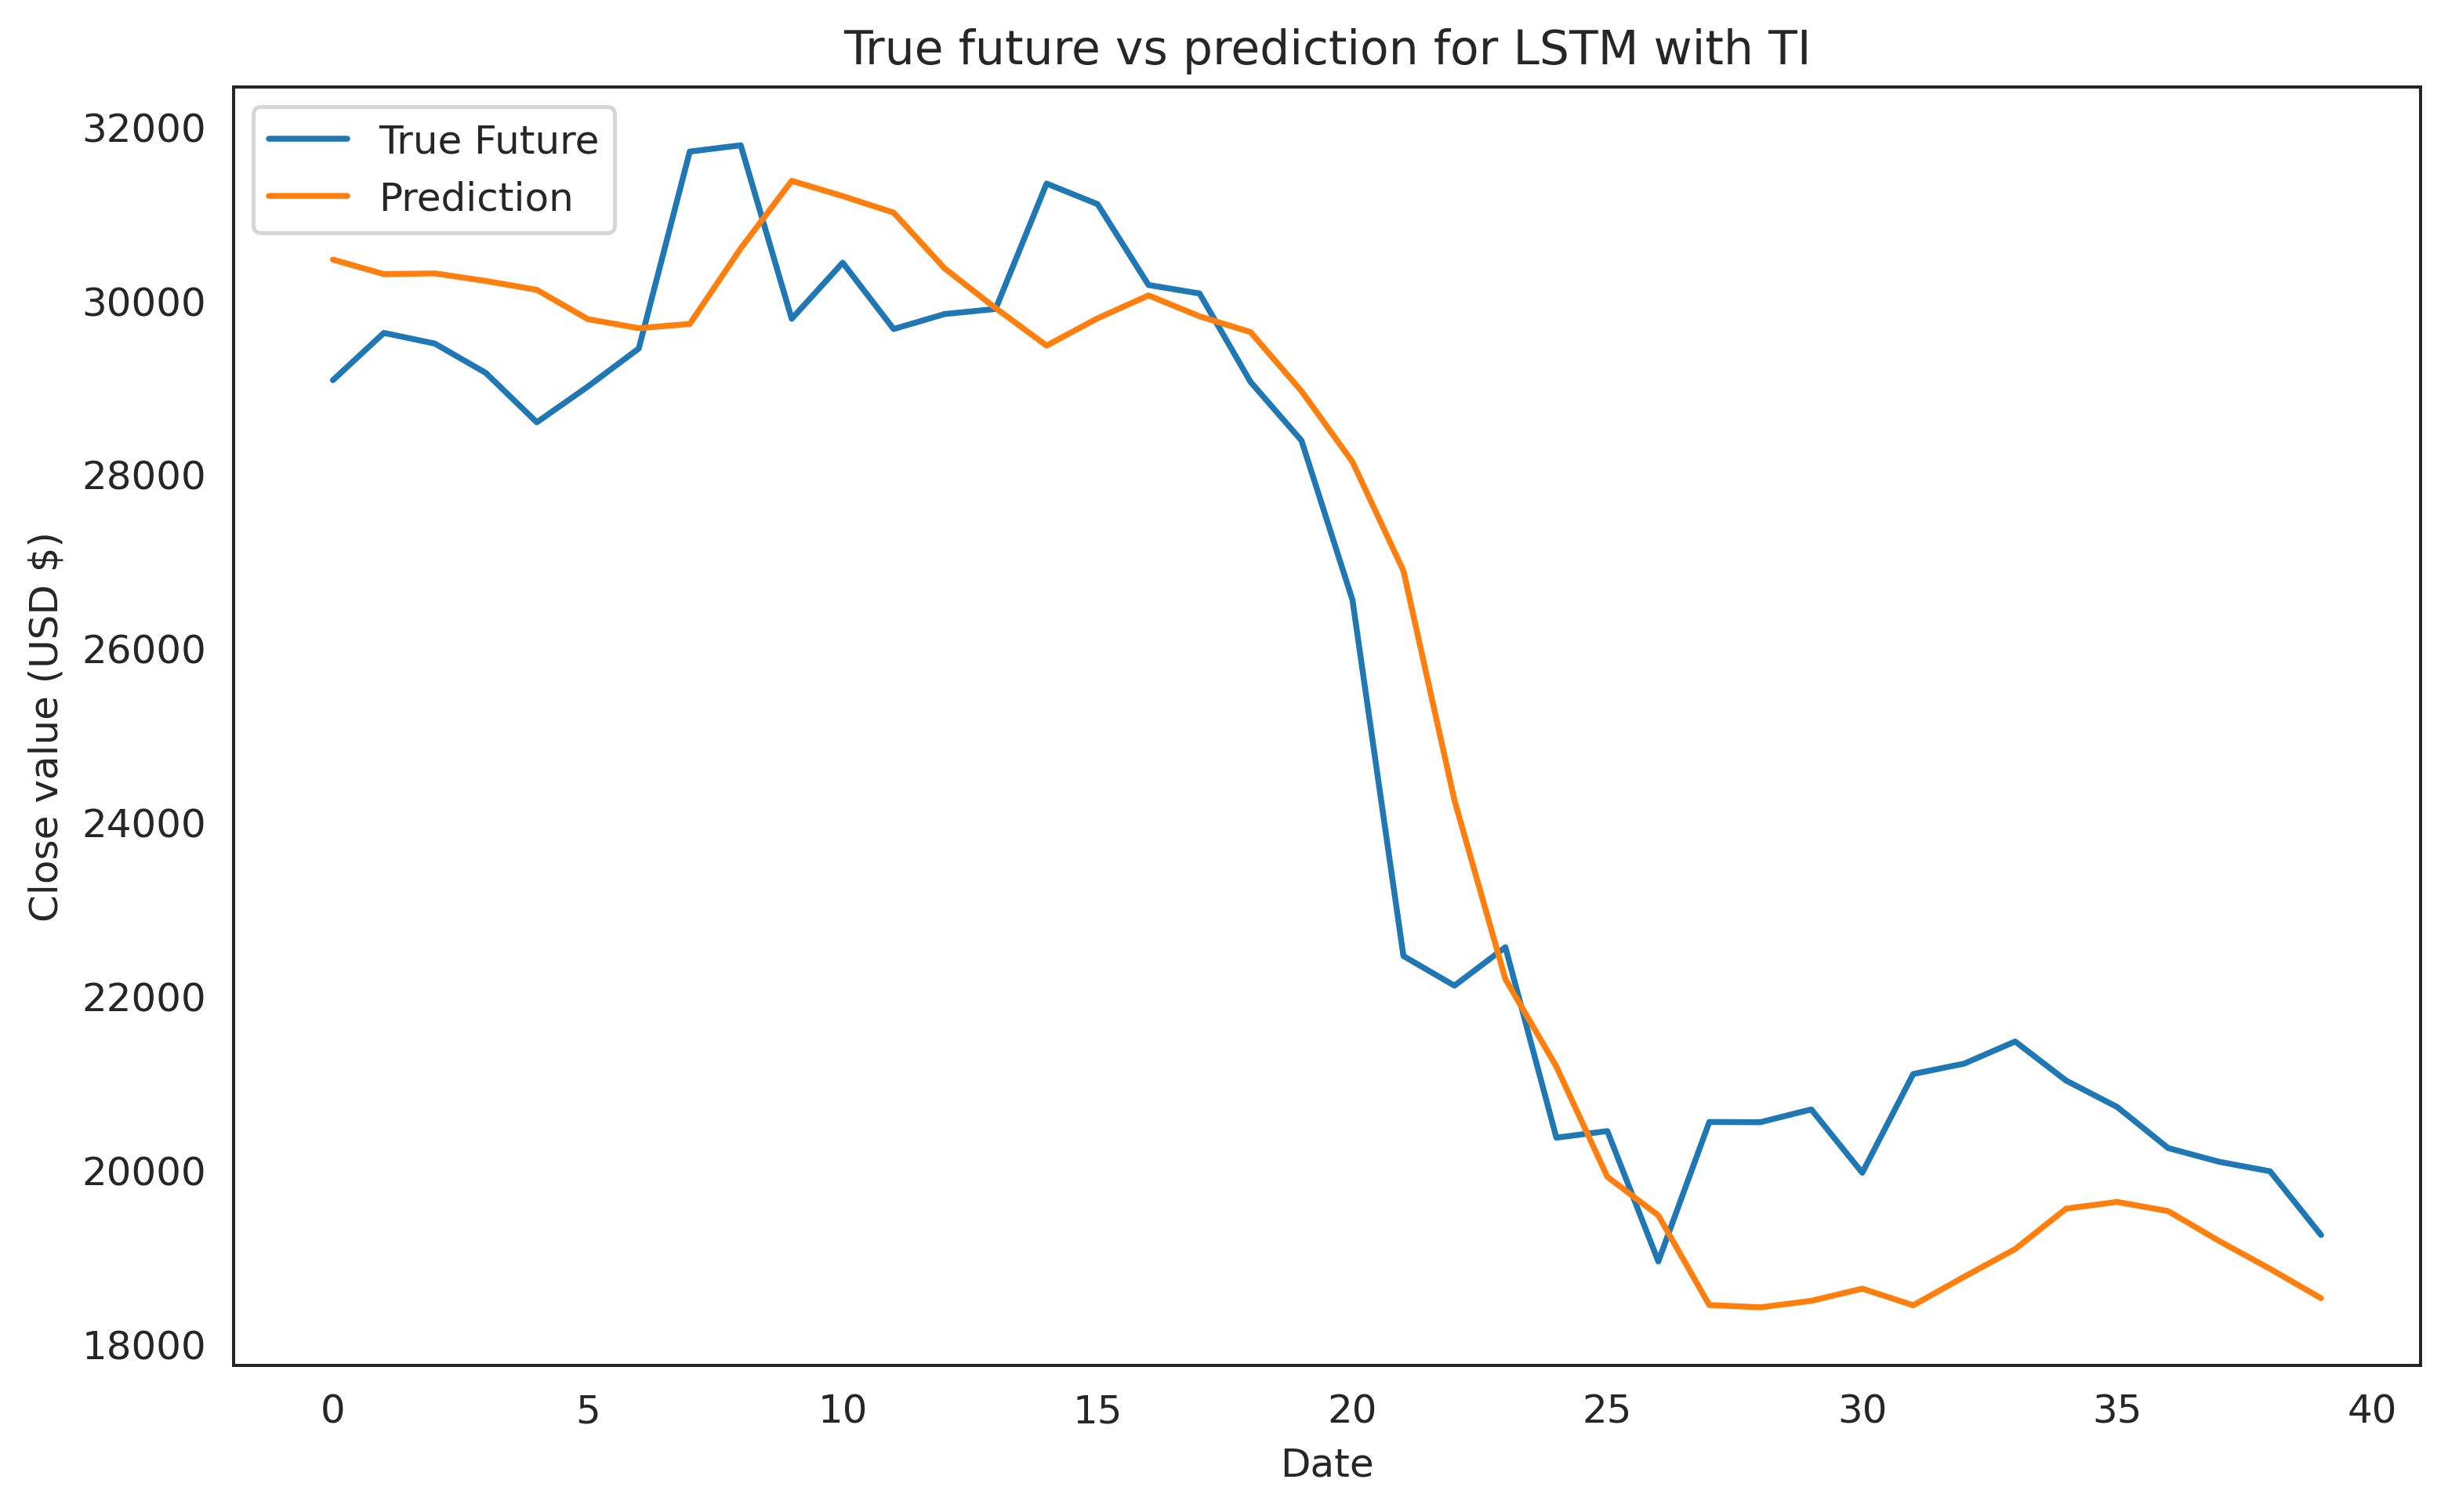

In [43]:
def plot_future(prediction, model_name, y_test):
    fig4 = plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')
    plt.title('True future vs prediction for ' + model_name + ' with TI')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
    fig4.savefig('True_future_vs_prediction_for_LSTM_with_TI.png')
plot_future(prediction_LSTM, 'LSTM', y_test)

In [44]:
y_test.shape

(40, 1)

In [45]:
## Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [46]:
evaluate_prediction(prediction_LSTM, y_test, 'LSTM-with-TI')

LSTM-with-TI:
Mean Absolute Error: 1256.3743
Root Mean Square Error: 1520.5052

